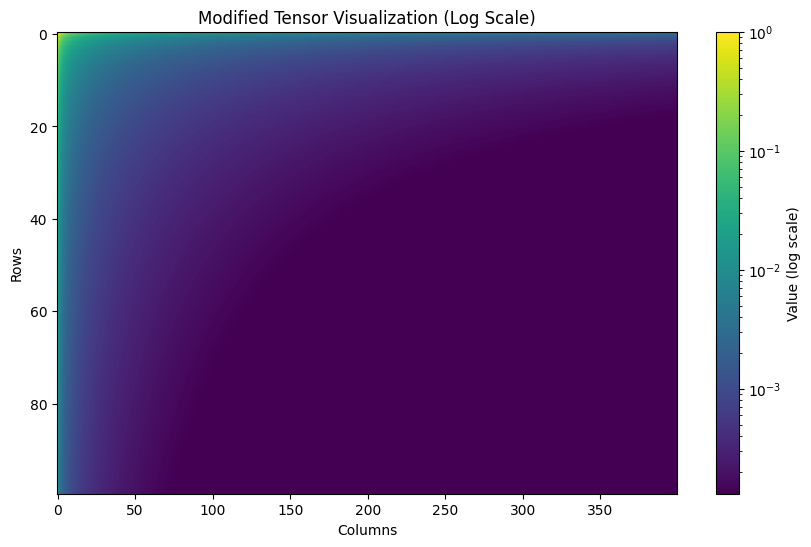

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Parameters
n = 100

# Create the n x 4n tensor
tensor = torch.tensor([[1 / (i * j) for j in range(1, 4 * n + 1)] for i in range(1, n + 1)])

# Calculate the median
median_value = torch.median(tensor)

# Replace entries smaller than the median with the median
tensor = torch.where(tensor < median_value, median_value, tensor)

# Convert tensor to a numpy array for visualization
tensor_np = tensor.numpy()

# Plotting the tensor with imshow and a log scale colorbar
plt.figure(figsize=(10, 6))
plt.imshow(tensor_np, norm=LogNorm(), cmap='viridis', aspect='auto')
plt.colorbar(label='Value (log scale)')
plt.title('Modified Tensor Visualization (Log Scale)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


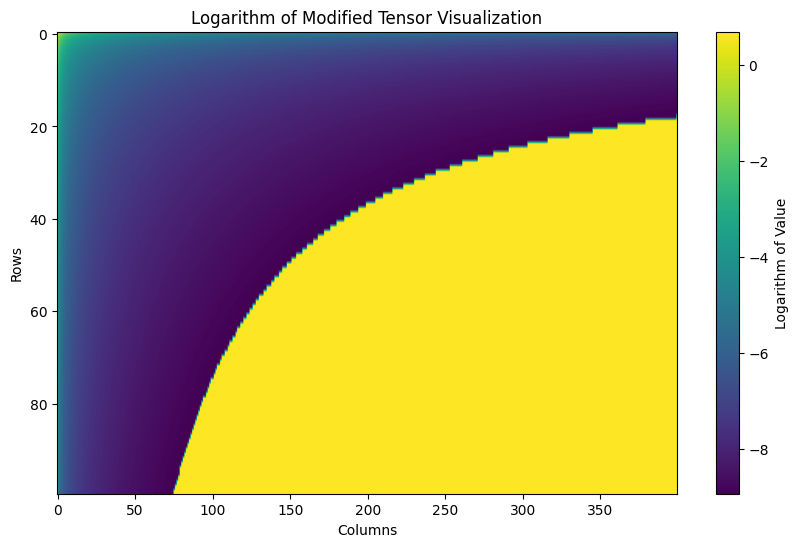

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 100

# Create the n x 4n tensor
tensor = torch.tensor([[1 / (i * j) for j in range(1, 4 * n + 1)] for i in range(1, n + 1)])

# Calculate the median
median_value = torch.median(tensor)

# Replace entries smaller than the median with the median
tensor = torch.where(tensor < median_value, 2.0, tensor)

# Take the logarithm of the tensor values
log_tensor = torch.log(tensor)

# Convert tensor to a numpy array for visualization
log_tensor_np = log_tensor.numpy()

# Plotting the logarithm of the tensor
plt.figure(figsize=(10, 6))
plt.imshow(log_tensor_np, cmap='viridis', aspect='auto')
plt.colorbar(label='Logarithm of Value')
plt.title('Logarithm of Modified Tensor Visualization')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


In [7]:
def matrix_power_psd(matrix, power):
    """
    Compute the power of a PSD matrix using eigendecomposition.
    
    Args:
        matrix (torch.Tensor): The PSD matrix (n x n).
        power (float): The exponent to which the matrix is raised.
    
    Returns:
        torch.Tensor: The resulting matrix after raising to the specified power.
    """
    # Perform eigendecomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(matrix)
    
    # Raise the eigenvalues to the specified power
    powered_eigenvalues = torch.diag(eigenvalues.clamp(min=0) ** power)
    
    # Reconstruct the matrix
    matrix_powered = eigenvectors @ powered_eigenvalues @ eigenvectors.T
    
    return matrix_powered

Condition number for method 1: 2.0000176429748535
Condition number for method 2: 111.51974487304688
Condition number for method 3: 1.8999139070510864


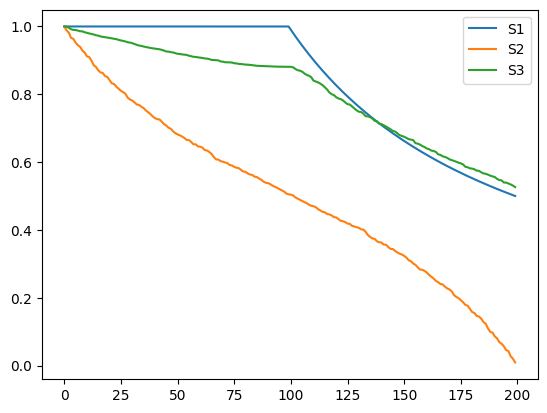

In [17]:
import torch

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate eigenvalues (1/i for i = 1, 2, ..., 200)
n = 200
eigenvalues = torch.tensor([1 / i for i in range(1, n + 1)], dtype=torch.float32)

# Generate a random orthonormal matrix Q using QR decomposition
random_matrix = torch.randn(n, n)
Q, _ = torch.linalg.qr(random_matrix)

# Create diagonal matrix D and compute P = QDQ^T
D = torch.diag(eigenvalues)
P = Q @ D @ Q.T

# Whitening method 1: M = Q^T D_2 Q
D_2 = torch.diag(torch.cat((torch.arange(1, n // 2 + 1, dtype=torch.float32), 
                            torch.full((n - n // 2,), n // 2, dtype=torch.float32))))
# print(D_2)

M = Q @ D_2 @ Q.T
P_whitened_1 = P @ M

# Whitening method 2: [[P_1^{-1}, 0], [0, P_2^{-1}]]

z = n//2

P_1 = P[:z, :z]
P_2 = P[z:, z:]
P_1_powered = matrix_power_psd(P_1, -.5)
P_2_powered = matrix_power_psd(P_2, -.5)
block_diag_powered = torch.block_diag(P_1_powered, P_2_powered)
P_whitened_2 = block_diag_powered @ P @ block_diag_powered

z1 = 100

D_3 = torch.diag(torch.cat((torch.arange(1, z1 + 1, dtype=torch.float32), 
                            torch.full((n - z1,), z1, dtype=torch.float32))))

M_3 = Q @ D_3 @ Q.T
P_whitened_3 = P @ M_3

P_31 = P_whitened_3[:z, :z]
P_32 = P_whitened_3[z:, z:]
P_31_powered = matrix_power_psd(P_31, -.25)
P_32_powered = matrix_power_psd(P_32, -.25)
block_diag_powered_3 = torch.block_diag(P_31_powered, P_32_powered)
P_whitened_3 = block_diag_powered_3 @ P_whitened_3 @ block_diag_powered_3

# print(block_diag_powered)
# print(P_whitened_2)

# Compute condition numbers
cond_1 = torch.linalg.cond(P_whitened_1)
cond_2 = torch.linalg.cond(P_whitened_2)
cond_3 = torch.linalg.cond(P_whitened_3)
U1, S1, V1 = torch.linalg.svd(P_whitened_1)
U2, S2, V2 = torch.linalg.svd(P_whitened_2)
U3, S3, V3 = torch.linalg.svd(P_whitened_3)
print("Condition number for method 1:", cond_1.item())
print("Condition number for method 2:", cond_2.item())
print("Condition number for method 3:", cond_3.item())
# print(S1)
# print(S2)

S1 /= torch.max(S1)
S2 /= torch.max(S2)
S3 /= torch.max(S3)
import matplotlib.pyplot as plt

# plot S1 and S2
plt.plot(S1, label='S1')
plt.plot(S2, label='S2')
plt.plot(S3, label='S3')
plt.legend()
plt.show()
